<a href="https://colab.research.google.com/github/emh0841-code/Final-Team9/blob/main/%EA%B0%80%EC%84%A4%EA%B2%80%EC%A6%9D_9_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

# 필요한 라이브러리 임포트
import pandas as pd # 데이터 분석 라이브러리
import numpy as np
import matplotlib.pyplot as plt # 시각화 도구 라이브러리1
import seaborn as sns # 시각화 도구 라이브러리2

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

df = pd.read_csv("/content/TMDB_processed_final.csv")

In [147]:
try:
    from statsmodels.stats.multitest import multipletests
except Exception:
    multipletests = None

RUNTIME_ORDER = ["120분 미만", "120분 이상"]
Y_COLS = [1, 2, 3]

def ensure_runtime_group(df):
    out = df.copy()
    if "runtime_group" not in out.columns:
        out["runtime"] = pd.to_numeric(out["runtime"], errors="coerce")
        out["runtime_group"] = np.where(out["runtime"] >= 120, "120분 이상", "120분 미만")
    return out

def prepare_y(df):
    out = df.copy()
    out["y_result"] = pd.to_numeric(out["y_result"], errors="coerce").astype("Int64")
    return out[out["y_result"].isin(Y_COLS)]

def make_ct(df_sub):
    """(런타임×y_result) 개수표, 비율표(%)"""
    ct = (pd.crosstab(df_sub["runtime_group"], df_sub["y_result"])
            .reindex(index=RUNTIME_ORDER, columns=Y_COLS, fill_value=0))
    ratio = (ct.div(ct.sum(1).replace(0, np.nan), axis=0) * 100).round(1)
    return ct, ratio

#  검정
from scipy.stats import chi2_contingency
from scipy.stats import norm # Import norm for z-test

def test_block(ct):
    """카이제곱 + Cramér's V + 기대빈도 + y=3 두 비율 검정까지 한 번에"""
    out = {"N_total": int(ct.values.sum())}

    # 카이제곱
    if out["N_total"] == 0 or (ct.sum(0)==0).any() or (ct.sum(1)==0).any():
        out.update({"chi2": np.nan, "dof": np.nan, "p_chi2": np.nan,
                    "V": np.nan, "exp_lt5_pct": np.nan})
    else:
        chi2, p, dof, expected = chi2_contingency(ct)
        n = out["N_total"]; k = min(ct.shape)
        V = np.sqrt(chi2 / (n * (k - 1))) if n>0 and k>1 else np.nan
        out.update({
            "chi2": chi2, "dof": dof, "p_chi2": p, "V": V,
            "exp_lt5_pct": (expected < 5).mean() * 100
        })

    # y=3 두 비율 검정
    try:
        s0, s1 = float(ct.loc["120분 미만", 3]), float(ct.loc["120분 이상", 3])
        n0, n1 = float(ct.loc["120분 미만"].sum()), float(ct.loc["120분 이상"].sum())
    except KeyError:
        s0=s1=n0=n1=np.nan

    if n0>0 and n1>0:
        p0, p1 = s0/n0, s1/n1
        diff = p1 - p0
        # 95% CI (unpooled)
        se_un = np.sqrt((p0*(1-p0))/n0 + (p1*(1-p1))/n1)
        ci = ( (diff - 1.96*se_un)*100, (diff + 1.96*se_un)*100 )
        # z-test (pooled)
        p_pool = (s0+s1)/(n0+n1)
        se_pool = np.sqrt(p_pool*(1-p_pool)*(1/n0 + 1/n1))
        z = diff/se_pool if se_pool>0 else np.nan
        p_two = 2*(1 - norm.cdf(abs(z))) if np.isfinite(z) else np.nan
        out.update({
            "y3_diff_pp": diff*100,
            "y3_ci_low_pp": ci[0], "y3_ci_high_pp": ci[1],
            "y3_z": z, "p_y3": p_two
        })
    else:
        out.update({
            "y3_diff_pp": np.nan, "y3_ci_low_pp": np.nan, "y3_ci_high_pp": np.nan,
            "y3_z": np.nan, "p_y3": np.nan
        })
    return out

In [152]:

df_run = ensure_runtime_group(df)
df_run = prepare_y(df_run)

# 2) 교차표(개수) & 비율표(%) 생성
ct, ratio = make_ct(df_run)

# 3) 보기 좋게 출력하는 함수
def print_results(ct, ratio):
    res = test_block(ct)  # 카이제곱 + V + 기대빈도 + (y=3) 두 비율 검정

    # 교차표(개수)
    print(" 교차표(ct)\n", ct.to_string(), "\n")

    # 요약표(개수 + 비율)
    summary = ct.assign(N=ct.sum(1)).join(ratio.add_suffix("(%)"))
    print(" 요약표(개수/비율)\n", summary.to_string(), "\n")

    # 검정 결과 (일반표기 + 지수표기를 함께)
    print(" 검정 결과")
    print(f"  N 총합            : {res['N_total']}")
    print(f"  Chi-square        : χ²={res['chi2']:.3f}, dof={res['dof']}, "
          f"p={res['p_chi2']:.6f}  (={res['p_chi2']:.3e})")
    print(f"  Cramér's V        : {res['V']:.3f}")
    print(f"  기대빈도<5 비율   : {res['exp_lt5_pct']:.1f}%")
    print(f"  [y=3] 비율(pp)   : {res['y3_diff_pp']:.1f}  "
          f"(95% CI [{res['y3_ci_low_pp']:.1f}, {res['y3_ci_high_pp']:.1f}])")
    print(f"       z, p(z-test) : z={res['y3_z']:.2f}, p={res['p_y3']:.6f}  (={res['p_y3']:.3e})")

# 4) 출력
print_results(ct, ratio)


 교차표(ct)
 y_result          1     2    3
runtime_group                 
120분 미만        1736  1455  646
120분 이상         613   570  410 

 요약표(개수/비율)
 y_result          1     2    3     N  1(%)  2(%)  3(%)
runtime_group                                         
120분 미만        1736  1455  646  3837  45.2  37.9  16.8
120분 이상         613   570  410  1593  38.5  35.8  25.7 

 검정 결과
  N 총합            : 5430
  Chi-square        : χ²=59.146, dof=2, p=0.000000  (=1.434e-13)
  Cramér's V        : 0.104
  기대빈도<5 비율   : 0.0%
  [y=3] 비율(pp)   : 8.9  (95% CI [6.4, 11.4])
       z, p(z-test) : z=7.55, p=0.000000  (=4.508e-14)


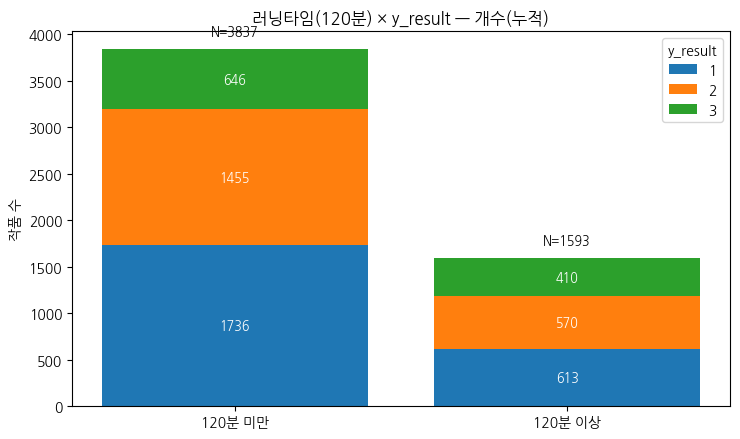

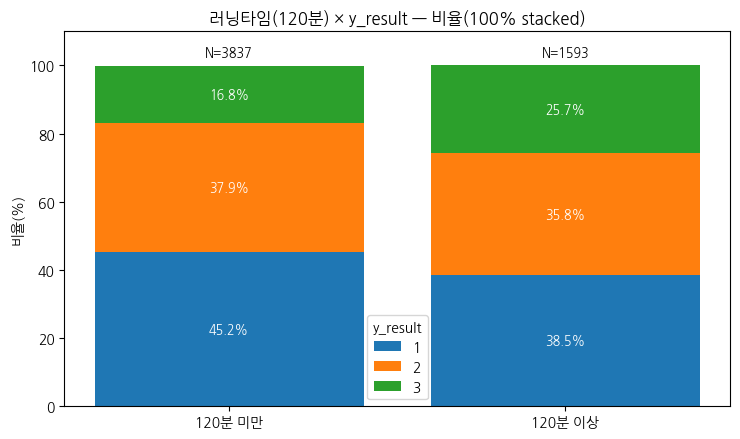

In [149]:
#시각화
fig, ax = plt.subplots(figsize=(7.5,4.5))
x = np.arange(len(ct))
bottom = np.zeros(len(ct))
for col in [1,2,3]:
    bars = ax.bar(x, ct[col].values, bottom=bottom, label=str(col))
    # 막대 내부 개수 라벨
    for rect, val in zip(bars, ct[col].values):
        if val > 0:
            ax.text(rect.get_x()+rect.get_width()/2, rect.get_y()+rect.get_height()/2,
                    f"{int(val)}", ha="center", va="center", fontsize=9, color="white")
    bottom += ct[col].values
# 총 N
totals = ct.sum(1).values
for xi, t in zip(x, totals):
    ax.text(xi, t + max(totals)*0.03, f"N={int(t)}", ha="center", va="bottom", fontsize=9)
ax.set_xticks(x, ct.index)
ax.set_ylabel("작품 수")
ax.set_title("러닝타임(120분) × y_result — 개수(누적)")
ax.legend(title="y_result")
plt.tight_layout(); plt.show()

# (B) 100% 누적 막대 (비율 + 퍼센트 라벨 + 총 N)
fig, ax = plt.subplots(figsize=(7.5,4.5))

x = np.arange(len(ratio))
bottom = np.zeros(len(ratio))      # 누적 시작점

for col in [1,2,3]:
    vals = ratio[col].values
    bars = ax.bar(x, vals, bottom=bottom, label=str(col))
    # 퍼센트 라벨(막대 내부 중앙)
    labels = [f"{v:.1f}%" if v >= min_pct_to_label and v > 0 else "" for v in vals]
    ax.bar_label(bars, labels=labels, label_type="center", fontsize=9, color="white")
    bottom += vals

ax.set_xticks(x, ratio.index)
ax.set_ylabel("비율(%)")
ax.set_title("러닝타임(120분) × y_result — 비율(100% stacked)")
ax.legend(title="y_result")

N = ct.sum(axis=1).reindex(ratio.index).values
ax.set_ylim(0, 110)                # 100% 위에 라벨 공간 확보
for xi, t in zip(x, N):
    ax.text(xi, 102, f"N={int(t)}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [150]:
year = pd.to_datetime(df2["release_date"], errors="coerce").dt.year
def era(y):
    if pd.isna(y): return np.nan
    if y < 2000:   return "2000년 이전"
    if y < 2010:   return "2000년대"
    if y < 2020:   return "2010년대"
    return "2020년대"
df2["era_group"] = year.map(era)

# 정리
era_order    = ["2000년 이전","2000년대","2010년대","2020년대"]
runtime_order= ["120분 미만","120분 이상"]
df2 = df2[df2["era_group"].notna()].copy()
df2["era_group"] = pd.Categorical(df2["era_group"], categories=era_order, ordered=True)

# (연대×런타임)×y_result 교차표(개수/비율)
idx = pd.MultiIndex.from_product([era_order, runtime_order], names=["era_group","runtime_group"])
ct_era = (pd.crosstab([df2["era_group"], df2["runtime_group"]], df2["y_result"])
            .reindex(idx, fill_value=0).reindex(columns=[1,2,3], fill_value=0))
ratio_era = (ct_era.div(ct_era.sum(1).replace(0, np.nan), axis=0)*100).fillna(0).round(1)

summary_era = ct_era.assign(N=ct_era.sum(1)).join(ratio_era.add_suffix("(%)")).reset_index()
print("\n (연대×런타임)별 y_result 개수/비율 요약")
print(summary_era[["era_group","runtime_group","N",1,2,3,"1(%)","2(%)","3(%)"]].to_string(index=False))

#  연대별 카이제곱 p-value
print("\n 연대별 카이제곱 p-value (런타임 ↔ y_result)")
from scipy.stats import chi2_contingency
for era in era_order:
    sub = df2[df2["era_group"]==era]
    tab = pd.crosstab(sub["runtime_group"], sub["y_result"]).reindex(
        index=runtime_order, columns=[1,2,3], fill_value=0)
    if tab.values.sum()>0 and (tab.sum(0)>0).all() and (tab.sum(1)>0).all():
        p = chi2_contingency(tab)[1]
        print(f"{era}: p = {p:.6f} (N={int(tab.values.sum())})")
    else:
        print(f"{era}: p = NA (표본 부족)")


 (연대×런타임)별 y_result 개수/비율 요약
era_group runtime_group    N   1   2   3  1(%)  2(%)  3(%)
 2000년 이전       120분 미만 1532 697 664 171  45.5  43.3  11.2
 2000년 이전       120분 이상  525 191 199 135  36.4  37.9  25.7
   2000년대       120분 미만 1008 476 339 193  47.2  33.6  19.1
   2000년대       120분 이상  390 149 151  90  38.2  38.7  23.1
   2010년대       120분 미만 1156 502 401 253  43.4  34.7  21.9
   2010년대       120분 이상  589 234 196 159  39.7  33.3  27.0
   2020년대       120분 미만  141  61  51  29  43.3  36.2  20.6
   2020년대       120분 이상   89  39  24  26  43.8  27.0  29.2

 연대별 카이제곱 p-value (런타임 ↔ y_result)
2000년 이전: p = 0.000000 (N=2057)
2000년대: p = 0.009391 (N=1398)
2010년대: p = 0.054865 (N=1745)
2020년대: p = 0.209407 (N=230)


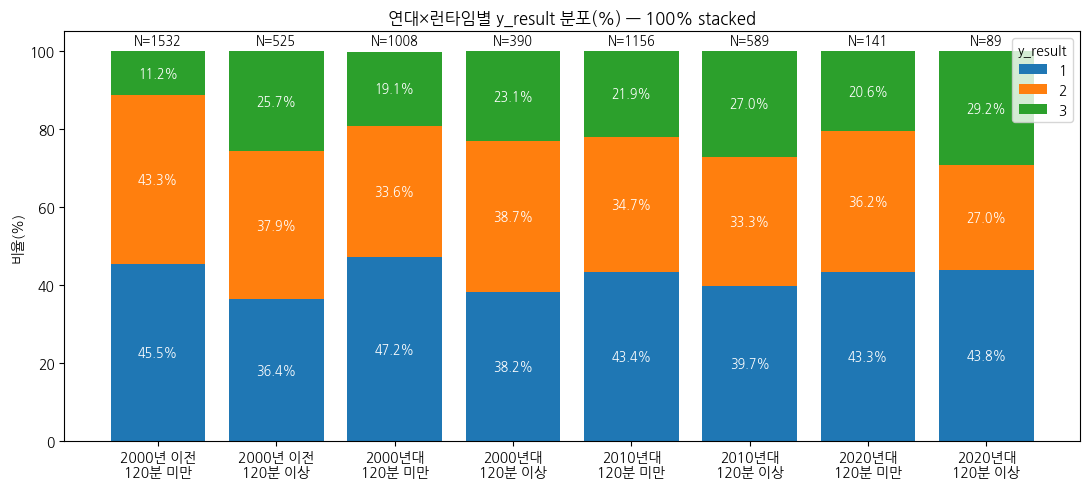

In [151]:
plot_r = ratio_era.reset_index()
plot_r["group"] = plot_r["era_group"] + "\n" + plot_r["runtime_group"]
plot_r = plot_r.set_index("group")[[1,2,3]]
fig, ax = plt.subplots(figsize=(11,5))
x = np.arange(len(plot_r))
bottom = np.zeros(len(plot_r))

for col in [1,2,3]:
    vals = plot_r[col].values
    bars = ax.bar(x, vals, bottom=bottom, label=str(col))
    # 퍼센트 라벨
    labels = [f"{v:.1f}%" if v >= min_pct_to_label and v > 0 else "" for v in vals]
    ax.bar_label(bars, labels=labels, label_type="center", fontsize=9, color="white")
    bottom += vals

ax.set_xticks(x, plot_r.index)
ax.set_ylabel("비율(%)")
ax.set_title("연대×런타임별 y_result 분포(%) — 100% stacked")
ax.legend(title="y_result")

N = (ct_era.sum(axis=1)  # y=1,2,3 합
     .rename("N")
     .reset_index())
N["group"] = N["era_group"] + "\n" + N["runtime_group"]
N = N.set_index("group").reindex(plot_r.index)["N"].values  # x축 순서에 맞춤

for xi, t in zip(x, N):
    ax.text(xi, 100 + 1.0, f"N={int(t)}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


